# Coming from Nengo to NengoDL

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/from-nengo.ipynb)

NengoDL combines two frameworks: Nengo and TensorFlow.  This tutorial is designed for people who are familiar with Nengo and looking to take advantage of the new features of NengoDL.  For the other approach, users familiar with TensorFlow looking to learn how to use NengoDL, check out [this tutorial](https://www.nengo.ai/nengo-dl/examples/from-tensorflow.html).

## Simulating a network with NengoDL

We'll begin by defining a simple Nengo network to use as an example.  The goal of our network will be to compute $sin(x^2)$.  There is nothing particularly significant about this network or function; the same principles we will discuss here could be applied to any Nengo model.

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import nengo
import numpy as np
import tensorflow as tf

import nengo_dl


warnings.simplefilter("ignore")

# we'll control the random seed in this example to make sure things stay
# consistent, but the results don't depend significantly on the seed
# (try changing it to verify)
seed = 0
np.random.seed(seed)

In [2]:
with nengo.Network(seed=seed) as net:    
    # input node outputting a random signal for x
    inpt = nengo.Node(nengo.processes.WhiteSignal(1, 5, rms=0.3))
    
    # first ensemble, will compute x^2
    square = nengo.Ensemble(20, 1)
    
    # second ensemble, will compute sin(x^2)
    sin = nengo.Ensemble(20, 1)
    
    # output node
    outpt = nengo.Node(size_in=1)
    
    # connect everything together
    nengo.Connection(inpt, square)
    nengo.Connection(square, sin, function=np.square)
    nengo.Connection(sin, outpt, function=np.sin)
    
    # add a probe on the input and output
    inpt_p = nengo.Probe(inpt)
    outpt_p = nengo.Probe(outpt, synapse=0.01)

We can simulate this network in the regular Nengo simulator:

In [3]:
with nengo.Simulator(net, seed=seed) as sim:
    sim.run(1.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

And plot the output:

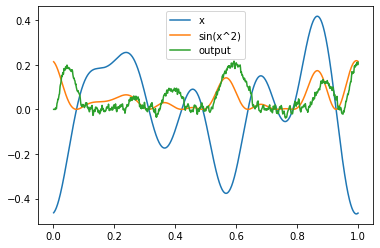

In [4]:
def plot(plot_sim, ax=None, idx=slice(None)):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    ax.plot(plot_sim.trange(), plot_sim.data[inpt_p][idx], label="x")
    ax.plot(plot_sim.trange(), np.sin(plot_sim.data[inpt_p][idx] ** 2),
            label="sin(x^2)")
    ax.plot(plot_sim.trange(), plot_sim.data[outpt_p][idx], label="output")
    ax.legend()


plot(sim)

To run the same network in NengoDL, all we need to do is switch `nengo.Simulator` to `nengo_dl.Simulator`:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|                         Constructing graph        #                 | 0:00:05

|                         Constructing graph         #                | 0:00:05

|                         Constructing graph          #               | 0:00:05

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#######       Constructing graph: build stage (11%)             | ETA: 0:00:00

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

|##############Constructing graph: build stage (77%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|                         Constructing graph             #            | 0:00:05

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:05                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

|          #                  Simulating                              | 0:00:01

|           #                 Simulating                              | 0:00:01

|            #                Simulating                              | 0:00:01

|             #               Simulating                              | 0:00:01

Simulation finished in 0:00:01                                                 

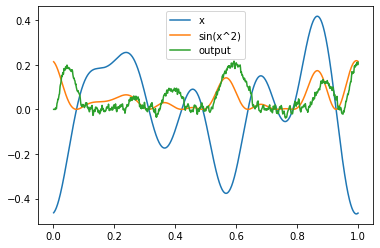

In [5]:
with nengo_dl.Simulator(net, seed=seed) as sim:
    sim.run(1.0)
    
plot(sim)

Note that the output of the NengoDL simulator is the same as the standard Nengo simulator.  Switching to NengoDL will not impact the behaviour of a model at all (ignoring very minor floating point math differences); any model that can run in Nengo will also run in NengoDL and produce the same output.

However, NengoDL adds a number of new features on top of the standard Nengo simulator, which we will explore next.

## Batch processing

Often when testing a model we want to run it several times with different input values.  In regular Nengo we can achieve this by calling `sim.run` several times, resetting between each run:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

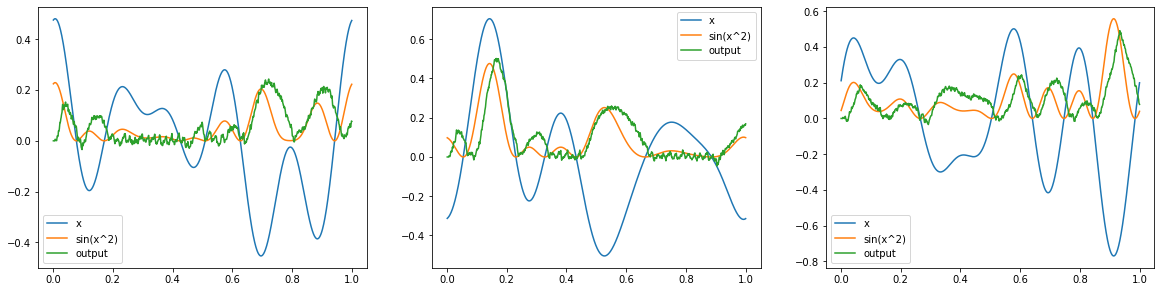

In [6]:
reps = 3

with nengo.Simulator(net) as sim:
    _, axes = plt.subplots(1, reps, figsize=(20, 4.8))
    for i in range(reps):
        sim.run(1.0)
        plot(sim, ax=axes[i])

        sim.reset(seed=i+10)

Note that simulating `n` different input sequences in this way takes `n` times as long as a single input sequence.

NengoDL, on the other hand, allows us to run several input values through the network in parallel.  This is known as "batch processing".  This can significantly improve the simulation time, as we can parallelize the computations and achieve much better than linear scaling.

This is controlled through the `minibatch_size` parameter of the NengoDL simulator.  To accomplish the same thing as above, but with a single parallelized call to `sim.run`, we can do:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#######       Constructing graph: build stage (11%)             | ETA: 0:00:00

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

|##############Constructing graph: build stage (77%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|   #                     Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

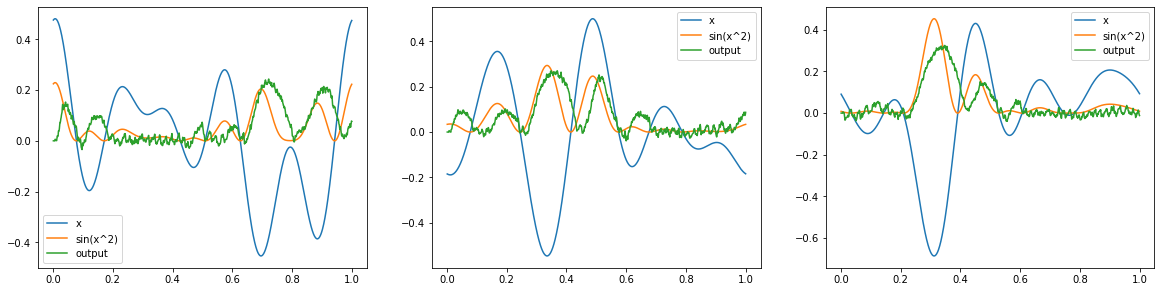

In [7]:
with nengo_dl.Simulator(net, minibatch_size=reps) as sim:
    sim.run(1.0)
    
_, axes = plt.subplots(1, reps, figsize=(20, 4.8))
for i in range(reps):
    plot(sim, ax=axes[i], idx=i)

Note that in this case the inputs and outputs aren't matching between the two simulators because we're not worrying about controlling the random seed.  But we can see that the network has run three different simulations in a single parallel run.

## Specifying model inputs at run time

In standard Nengo, input values are specified in the model definition (when we create a `nengo.Node`).  At run time, the model is then simulated with those input values every time; if we want to change the input values, we need to change the `Node`.  However, it can be useful to dynamically specify the input values at run time, so that we can simulate the model with different input values without changing our model definition.  

NengoDL supports this through the `data` argument.  This is a dictionary that maps Nodes to arrays, where each array has shape `(minibatch_size, n_steps, node_size)`.  `minibatch_size` refers to the `Simulator.minibatch_size` parameter discussed in the previous section, `n_steps` is the number of simulation time steps, and `node_size` is the output dimensionality of the `Node`.

For example, we could simulate our network with a linear ramp input:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#######       Constructing graph: build stage (11%)             | ETA: 0:00:00

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

|##############Constructing graph: build stage (77%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

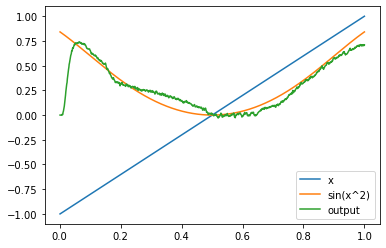

In [8]:
with nengo_dl.Simulator(net) as sim:
    sim.run(1.0, data={inpt: np.reshape(np.linspace(-1, 1, 1000), 
                                        (1, 1000, 1))})

plot(sim)

Note that we didn't change the model definition at all.  In theory, our Node is still outputting the same random signal, but we overrode that with the values in `data`.

This functionality is particularly useful in concert with batch processing, as it allows us to provide different input values for each item in the batch.  For example, we could run each batch item with a different ramp input:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#######       Constructing graph: build stage (11%)             | ETA: 0:00:00

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

|##############Constructing graph: build stage (77%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|   #                     Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

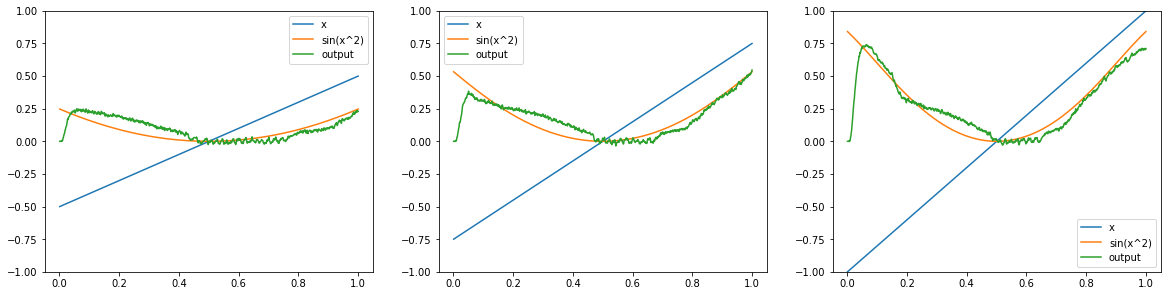

In [9]:
with nengo_dl.Simulator(net, minibatch_size=reps) as sim:
    sim.run(1.0, data={
        inpt: (np.linspace(0.5, 1, reps)[:, None, None]
               * np.linspace(-1, 1, 1000)[None, :, None])})
    
_, axes = plt.subplots(1, reps, figsize=(20, 4.8))
for i in range(reps):
    plot(sim, ax=axes[i], idx=i)
    axes[i].set_ylim((-1, 1))

## Optimizing model parameters

By default, Nengo uses the [Neural Engineering Framework](http://compneuro.uwaterloo.ca/research/nef.html) to optimize the parameters of a model.  NengoDL adds a new set of optimization tools (deep learning training methods) to that toolkit, which can be used instead of or in addition to the NEF optimization.

Which techniques work best will depend on the particular model being developed.  However, as a general rule of thumb the deep learning methods will tend to take longer but provide more accurate network output.  One reason for this is that deep learning methods can jointly optimize across all the parameters in the network (e.g., adjusting the decoders for multiple chained connections so that they work together to compute a function), whereas the NEF optimization is applied to each connection individually.  Deep learning methods can also optimize all the parameters in a network (encoders, decoders, and biases), whereas NEF methods are only applied to decoders.  We'll illustrate this difference in this example by using a hybrid approach, where we use the NEF to compute the decoders and deep learning methods to optimize encoders and biases.

First we're going to make some changes to the model itself.  We created the model with the default synaptic filter of `nengo.Lowpass(tau=0.005)` on all the Connections.  This makes sense when we're working with a spiking model, as the filters reduce the spike noise in the communication between Ensembles.  However, when we're training a network in NengoDL the synaptic filters introduce more complex temporal dynamics into the optimization problem.  This is not necessarily a bad thing, as those temporal dynamics may be something we care about and want to optimize for.  But in this instance we don't particularly care about the synaptic dynamics.  During training NengoDL will automatically be swapping the spiking `nengo.LIF` neuron model for the non-spiking `nengo.LIFRate`, so we don't need the synaptic filters to reduce spike noise.  And because this is a simple feedforward network, there aren't any other temporal dynamics in the system that the synaptic filtering would interact with.  So we can simplify our optimization problem by removing the synaptic filters, without significantly changing the behaviour of our model.

In [10]:
# set all the connection synapses to None
for conn in net.all_connections:
    conn.synapse = None
    
# add a new probe that doesn't have a synaptic filter on it
# (we'll keep the original probe with the synaptic filter
# as well, since we'll have uses for both)
with net:
    outpt_p_nofilt = nengo.Probe(outpt)

# increase the filtering on our output probe (to compensate
# for the fact that we removed the internal synaptic filters)
outpt_p.synapse = 0.04

We can verify that our network still produces roughly the same output after these changes.

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

| #                       Constructing graph                          | 0:00:00

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|####          Constructing graph: build stage (6%)              | ETA: 0:00:01

|##############Constructing graph: build stage (31%)             | ETA: 0:00:00

|##############Constructing graph: build stage (37%)             | ETA: 0:00:00

|##############Constructing graph: build stage (62%)             | ETA: 0:00:00

|##############Constructing graph: build stage (93%)#########    | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|    #                    Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

|          #                  Simulating                              | 0:00:01

Simulation finished in 0:00:01                                                 

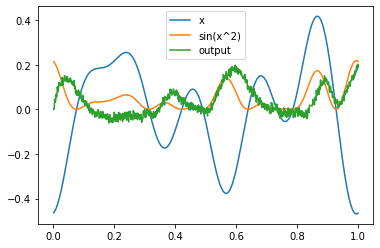

In [11]:
with nengo_dl.Simulator(net, seed=seed) as sim:
    sim.run(1.0)
    plot(sim)

Next we will select how we want to optimize this network.  As discussed above, in this example we're going to leave the decoders the same, and apply our deep learning optimization to the encoders and biases.  We can control which parts of a model will be optimized through the `trainable` configuration attribute.  More details on how this works can be found [in the documentation](https://www.nengo.ai/nengo-dl/config.html#trainable).

In [12]:
with net:
    # disable optimization on all parameters by default
    nengo_dl.configure_settings(trainable=False)
    
    # re-enable training on Ensembles (encoders and biases)
    net.config[nengo.Ensemble].trainable = True

Next we need to define our training data.  This consists of two parts: input values for Nodes, and target values for Probes.  These indicate that when the network receives the given input values, we want to see the corresponding target values at the probe.  The data is specified as a dictionary mapping nodes/probes to arrays.  This is much the same as the `data` argument introduced above, and the arrays have a similar shape `(batch_size, n_steps, node/probe_size)`.  Note that `batch_size` in this case can be greater than `minibatch_size`, and the data will automatically be divided up into `minibatch_size` chunks during training.

In this example `n_steps` will just be 1, meaning that we will only be optimizing the model parameters with respect to a single timestep of inputs and outputs.  Because we have eliminated the temporal dynamics in our model by removing the synaptic filters, each timestep can be treated independently.  That is, training with a batch size of 1 for 1000 timesteps is the same as training with a batch size of 1000 for 1 timestep.  And the latter is preferred, as the computations will be more efficient when we can divide them into minibatches and parallelize them.

Note that if our model had temporal dynamics (e.g., through recurrent connections or synaptic filters) then it would be important to train with `n_steps>1`, in order to capture those dynamics.  But we don't need to worry about that in this case, nor in many common deep-learning-style networks, so we'll keep things simple.  See [this example](https://www.nengo.ai/nengo-dl/examples/spa-memory) for a more complex problem where temporal dynamics are involved.

In [13]:
batch_size = 4096
minibatch_size = 32
n_steps = 1

# create random input data
vals = np.random.uniform(-1, 1, size=(batch_size, n_steps, 1))

# create data dictionaries
inputs = {inpt: vals}
targets = {outpt_p_nofilt: np.sin(vals**2)}

Now we are ready to optimize our model.  This is done through the `sim.compile` and `sim.fit` functions.  In addition to the `inputs/targets`, there are three more arguments we need to think about.

The first is which deep learning optimization algorithm we want to use when training the network.  Essentially these algorithms define how to turn an error value into a change in the model parameters (with the goal being to reduce the error).  There are [many options available](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), which we will not go into here.  We'll use RMSProp, which is a decent default in many cases.

Second, we need to think about the objective function.  This is the function that computes an error value given the network outputs (for example, by computing the difference between the output and target values).  Again there are [many options here](https://www.tensorflow.org/api_docs/python/tf/keras/losses) that we will not go into; choosing an appropriate objective function depends on the nature of a particular task.  In this example we will use mean squared error, which is generally a good default.

The third parameter we'll set is `epochs`.  This determines how many training iterations we will execute; one epoch is one complete pass through the training data.  This is a parameter that generally needs to be set through trial and error; it will depend on the particular optimization task.

See [the documentation](https://www.nengo.ai/nengo-dl/simulator.html) for a more in-depth discussion of `sim.fit` parameters and usage.

|                     Building network (0%)                    | ETA:  --:--:--

|#####################Building network (81%)#########            | ETA: 0:00:00

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

| #                       Constructing graph                          | 0:00:00

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|####          Constructing graph: build stage (6%)              | ETA: 0:00:01

|##############Constructing graph: build stage (33%)             | ETA: 0:00:00

|##############Constructing graph: build stage (60%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|   #                     Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

Train on 4096 samples
Epoch 1/25


  32/4096 [..............................] - ETA: 0s - loss: 0.0020 - probe_2_loss: 0.0020

 384/4096 [=>............................] - ETA: 0s - loss: 0.0021 - probe_2_loss: 0.0021

 672/4096 [===>..........................] - ETA: 0s - loss: 0.0021 - probe_2_loss: 0.0021

 992/4096 [======>.......................] - ETA: 0s - loss: 0.0021 - probe_2_loss: 0.0021

1344/4096 [========>.....................] - ETA: 0s - loss: 0.0021 - probe_2_loss: 0.0021

1696/4096 [===========>..................] - ETA: 0s - loss: 0.0020 - probe_2_loss: 0.0020

2016/4096 [=============>................] - ETA: 0s - loss: 0.0020 - probe_2_loss: 0.0020

2368/4096 [================>.............] - ETA: 0s - loss: 0.0020 - probe_2_loss: 0.0020

2720/4096 [==================>...........] - ETA: 0s - loss: 0.0020 - probe_2_loss: 0.0020

3072/4096 [=====================>........] - ETA: 0s - loss: 0.0020 - probe_2_loss: 0.0020

3424/4096 [========================>.....] - ETA: 0s - loss: 0.0019 - probe_2_loss: 0.0019

3776/4096 [==========================>...] - ETA: 0s - loss: 0.0019 - probe_2_loss: 0.0019

4096/4096 [==============================] - 1s 155us/sample - loss: 0.0019 - probe_2_loss: 0.0019


Epoch 2/25
  32/4096 [..............................] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

 352/4096 [=>............................] - ETA: 0s - loss: 0.0018 - probe_2_loss: 0.0018

 640/4096 [===>..........................] - ETA: 0s - loss: 0.0018 - probe_2_loss: 0.0018

 992/4096 [======>.......................] - ETA: 0s - loss: 0.0018 - probe_2_loss: 0.0018

1280/4096 [========>.....................] - ETA: 0s - loss: 0.0018 - probe_2_loss: 0.0018

1536/4096 [==========>...................] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

1888/4096 [============>.................] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

2272/4096 [===============>..............] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

2624/4096 [==================>...........] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

2976/4096 [====================>.........] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

3360/4096 [=======================>......] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

3744/4096 [==========================>...] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

4096/4096 [==============================] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

4096/4096 [==============================] - 1s 155us/sample - loss: 0.0017 - probe_2_loss: 0.0017


Epoch 3/25
  32/4096 [..............................] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

 384/4096 [=>............................] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

 736/4096 [====>.........................] - ETA: 0s - loss: 0.0016 - probe_2_loss: 0.0016

1056/4096 [======>.......................] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

1408/4096 [=========>....................] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

1728/4096 [===========>..................] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

2080/4096 [==============>...............] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

2400/4096 [================>.............] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

2752/4096 [===================>..........] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

3104/4096 [=====================>........] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

3456/4096 [========================>.....] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

3808/4096 [==========================>...] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

4096/4096 [==============================] - 1s 150us/sample - loss: 0.0015 - probe_2_loss: 0.0015


Epoch 4/25


  32/4096 [..............................] - ETA: 0s - loss: 0.0019 - probe_2_loss: 0.0019

 384/4096 [=>............................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

 736/4096 [====>.........................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

1088/4096 [======>.......................] - ETA: 0s - loss: 0.0014 - probe_2_loss: 0.0014

1440/4096 [=========>....................] - ETA: 0s - loss: 0.0014 - probe_2_loss: 0.0014

1792/4096 [============>.................] - ETA: 0s - loss: 0.0014 - probe_2_loss: 0.0014

2112/4096 [==============>...............] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

2464/4096 [=================>............] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

2784/4096 [===================>..........] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

3136/4096 [=====================>........] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

3488/4096 [========================>.....] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

3840/4096 [===========================>..] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

4096/4096 [==============================] - 1s 150us/sample - loss: 0.0013 - probe_2_loss: 0.0013


Epoch 5/25


  32/4096 [..............................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 352/4096 [=>............................] - ETA: 0s - loss: 0.0014 - probe_2_loss: 0.0014

 704/4096 [====>.........................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

1056/4096 [======>.......................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

1344/4096 [========>.....................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

1696/4096 [===========>..................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

2048/4096 [==============>...............] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

2368/4096 [================>.............] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

2560/4096 [=================>............] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

2912/4096 [====================>.........] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

3200/4096 [======================>.......] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

3488/4096 [========================>.....] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

3840/4096 [===========================>..] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

4096/4096 [==============================] - 1s 164us/sample - loss: 0.0012 - probe_2_loss: 0.0012


Epoch 6/25
  32/4096 [..............................] - ETA: 0s - loss: 5.4211e-04 - probe_2_loss: 5.4211e-04

 416/4096 [==>...........................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011        

 704/4096 [====>.........................] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

1056/4096 [======>.......................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

1408/4096 [=========>....................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

1760/4096 [===========>..................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

2112/4096 [==============>...............] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

2464/4096 [=================>............] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

2816/4096 [===================>..........] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

3104/4096 [=====================>........] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

3456/4096 [========================>.....] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

3808/4096 [==========================>...] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

4096/4096 [==============================] - 1s 151us/sample - loss: 0.0011 - probe_2_loss: 0.0011


Epoch 7/25
  32/4096 [..............................] - ETA: 0s - loss: 9.7018e-04 - probe_2_loss: 9.7018e-04

 384/4096 [=>............................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011        

 736/4096 [====>.........................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

1088/4096 [======>.......................] - ETA: 0s - loss: 0.0010 - probe_2_loss: 0.0010

1408/4096 [=========>....................] - ETA: 0s - loss: 9.8778e-04 - probe_2_loss: 9.8778e-04

1728/4096 [===========>..................] - ETA: 0s - loss: 9.9512e-04 - probe_2_loss: 9.9512e-04

2080/4096 [==============>...............] - ETA: 0s - loss: 0.0010 - probe_2_loss: 0.0010        

2432/4096 [================>.............] - ETA: 0s - loss: 9.9234e-04 - probe_2_loss: 9.9234e-04

2752/4096 [===================>..........] - ETA: 0s - loss: 9.9388e-04 - probe_2_loss: 9.9388e-04

3072/4096 [=====================>........] - ETA: 0s - loss: 9.8517e-04 - probe_2_loss: 9.8517e-04

3392/4096 [=======================>......] - ETA: 0s - loss: 9.7406e-04 - probe_2_loss: 9.7406e-04

3744/4096 [==========================>...] - ETA: 0s - loss: 9.7134e-04 - probe_2_loss: 9.7134e-04

4096/4096 [==============================] - ETA: 0s - loss: 9.6337e-04 - probe_2_loss: 9.6337e-04

4096/4096 [==============================] - 1s 155us/sample - loss: 9.6337e-04 - probe_2_loss: 9.6337e-04


Epoch 8/25
  32/4096 [..............................] - ETA: 0s - loss: 7.7019e-04 - probe_2_loss: 7.7019e-04

 352/4096 [=>............................] - ETA: 0s - loss: 8.3446e-04 - probe_2_loss: 8.3446e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 8.8274e-04 - probe_2_loss: 8.8274e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 9.3942e-04 - probe_2_loss: 9.3942e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 9.1627e-04 - probe_2_loss: 9.1627e-04

1792/4096 [============>.................] - ETA: 0s - loss: 8.8969e-04 - probe_2_loss: 8.8969e-04

2144/4096 [==============>...............] - ETA: 0s - loss: 8.8051e-04 - probe_2_loss: 8.8051e-04

2496/4096 [=================>............] - ETA: 0s - loss: 8.7931e-04 - probe_2_loss: 8.7931e-04

2848/4096 [===================>..........] - ETA: 0s - loss: 8.7295e-04 - probe_2_loss: 8.7295e-04

3200/4096 [======================>.......] - ETA: 0s - loss: 8.7382e-04 - probe_2_loss: 8.7382e-04

3520/4096 [========================>.....] - ETA: 0s - loss: 8.6817e-04 - probe_2_loss: 8.6817e-04

3872/4096 [===========================>..] - ETA: 0s - loss: 8.6551e-04 - probe_2_loss: 8.6551e-04

4096/4096 [==============================] - 1s 151us/sample - loss: 8.6775e-04 - probe_2_loss: 8.6775e-04


Epoch 9/25


  32/4096 [..............................] - ETA: 0s - loss: 7.3504e-04 - probe_2_loss: 7.3504e-04

 384/4096 [=>............................] - ETA: 0s - loss: 7.7100e-04 - probe_2_loss: 7.7100e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 8.4493e-04 - probe_2_loss: 8.4493e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 8.1052e-04 - probe_2_loss: 8.1052e-04

1408/4096 [=========>....................] - ETA: 0s - loss: 8.0990e-04 - probe_2_loss: 8.0990e-04

1728/4096 [===========>..................] - ETA: 0s - loss: 8.1057e-04 - probe_2_loss: 8.1057e-04

2080/4096 [==============>...............] - ETA: 0s - loss: 8.1478e-04 - probe_2_loss: 8.1478e-04

2432/4096 [================>.............] - ETA: 0s - loss: 7.9140e-04 - probe_2_loss: 7.9140e-04

2784/4096 [===================>..........] - ETA: 0s - loss: 7.7976e-04 - probe_2_loss: 7.7976e-04

3104/4096 [=====================>........] - ETA: 0s - loss: 7.9628e-04 - probe_2_loss: 7.9628e-04

3456/4096 [========================>.....] - ETA: 0s - loss: 7.9207e-04 - probe_2_loss: 7.9207e-04

3808/4096 [==========================>...] - ETA: 0s - loss: 7.8541e-04 - probe_2_loss: 7.8541e-04

4096/4096 [==============================] - 1s 151us/sample - loss: 7.9131e-04 - probe_2_loss: 7.9131e-04


Epoch 10/25
  32/4096 [..............................] - ETA: 0s - loss: 5.0021e-04 - probe_2_loss: 5.0021e-04

 384/4096 [=>............................] - ETA: 0s - loss: 8.1481e-04 - probe_2_loss: 8.1481e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 7.8154e-04 - probe_2_loss: 7.8154e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 7.8875e-04 - probe_2_loss: 7.8875e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 7.9040e-04 - probe_2_loss: 7.9040e-04

1792/4096 [============>.................] - ETA: 0s - loss: 7.5638e-04 - probe_2_loss: 7.5638e-04

2144/4096 [==============>...............] - ETA: 0s - loss: 7.4977e-04 - probe_2_loss: 7.4977e-04

2496/4096 [=================>............] - ETA: 0s - loss: 7.4819e-04 - probe_2_loss: 7.4819e-04

2784/4096 [===================>..........] - ETA: 0s - loss: 7.3285e-04 - probe_2_loss: 7.3285e-04

3136/4096 [=====================>........] - ETA: 0s - loss: 7.3442e-04 - probe_2_loss: 7.3442e-04

3488/4096 [========================>.....] - ETA: 0s - loss: 7.3373e-04 - probe_2_loss: 7.3373e-04

3840/4096 [===========================>..] - ETA: 0s - loss: 7.2848e-04 - probe_2_loss: 7.2848e-04

4096/4096 [==============================] - 1s 149us/sample - loss: 7.2938e-04 - probe_2_loss: 7.2938e-04


Epoch 11/25


  32/4096 [..............................] - ETA: 0s - loss: 6.5562e-04 - probe_2_loss: 6.5562e-04

 352/4096 [=>............................] - ETA: 0s - loss: 6.9192e-04 - probe_2_loss: 6.9192e-04

 640/4096 [===>..........................] - ETA: 0s - loss: 7.1542e-04 - probe_2_loss: 7.1542e-04

 992/4096 [======>.......................] - ETA: 0s - loss: 6.9852e-04 - probe_2_loss: 6.9852e-04

1344/4096 [========>.....................] - ETA: 0s - loss: 7.0678e-04 - probe_2_loss: 7.0678e-04

1728/4096 [===========>..................] - ETA: 0s - loss: 6.9569e-04 - probe_2_loss: 6.9569e-04

2048/4096 [==============>...............] - ETA: 0s - loss: 6.8801e-04 - probe_2_loss: 6.8801e-04

2368/4096 [================>.............] - ETA: 0s - loss: 6.8833e-04 - probe_2_loss: 6.8833e-04

2720/4096 [==================>...........] - ETA: 0s - loss: 6.8100e-04 - probe_2_loss: 6.8100e-04

3072/4096 [=====================>........] - ETA: 0s - loss: 6.8719e-04 - probe_2_loss: 6.8719e-04

3392/4096 [=======================>......] - ETA: 0s - loss: 6.8892e-04 - probe_2_loss: 6.8892e-04

3744/4096 [==========================>...] - ETA: 0s - loss: 6.7990e-04 - probe_2_loss: 6.7990e-04

4096/4096 [==============================] - ETA: 0s - loss: 6.7858e-04 - probe_2_loss: 6.7858e-04

4096/4096 [==============================] - 1s 156us/sample - loss: 6.7858e-04 - probe_2_loss: 6.7858e-04


Epoch 12/25
  32/4096 [..............................] - ETA: 0s - loss: 7.1308e-04 - probe_2_loss: 7.1308e-04

 384/4096 [=>............................] - ETA: 0s - loss: 6.6587e-04 - probe_2_loss: 6.6587e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 6.6225e-04 - probe_2_loss: 6.6225e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 6.4518e-04 - probe_2_loss: 6.4518e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 6.4046e-04 - probe_2_loss: 6.4046e-04

1792/4096 [============>.................] - ETA: 0s - loss: 6.4057e-04 - probe_2_loss: 6.4057e-04

2144/4096 [==============>...............] - ETA: 0s - loss: 6.3964e-04 - probe_2_loss: 6.3964e-04

2496/4096 [=================>............] - ETA: 0s - loss: 6.5218e-04 - probe_2_loss: 6.5218e-04

2880/4096 [====================>.........] - ETA: 0s - loss: 6.5349e-04 - probe_2_loss: 6.5349e-04

3232/4096 [======================>.......] - ETA: 0s - loss: 6.3677e-04 - probe_2_loss: 6.3677e-04

3584/4096 [=========================>....] - ETA: 0s - loss: 6.3809e-04 - probe_2_loss: 6.3809e-04

3936/4096 [===========================>..] - ETA: 0s - loss: 6.3195e-04 - probe_2_loss: 6.3195e-04

4096/4096 [==============================] - 1s 147us/sample - loss: 6.3664e-04 - probe_2_loss: 6.3664e-04


Epoch 13/25
  32/4096 [..............................] - ETA: 0s - loss: 4.1527e-04 - probe_2_loss: 4.1527e-04

 320/4096 [=>............................] - ETA: 0s - loss: 6.1511e-04 - probe_2_loss: 6.1511e-04

 672/4096 [===>..........................] - ETA: 0s - loss: 6.1816e-04 - probe_2_loss: 6.1816e-04

1056/4096 [======>.......................] - ETA: 0s - loss: 6.3500e-04 - probe_2_loss: 6.3500e-04

1408/4096 [=========>....................] - ETA: 0s - loss: 6.4110e-04 - probe_2_loss: 6.4110e-04

1760/4096 [===========>..................] - ETA: 0s - loss: 6.3370e-04 - probe_2_loss: 6.3370e-04

2112/4096 [==============>...............] - ETA: 0s - loss: 6.3148e-04 - probe_2_loss: 6.3148e-04

2496/4096 [=================>............] - ETA: 0s - loss: 6.1882e-04 - probe_2_loss: 6.1882e-04

2816/4096 [===================>..........] - ETA: 0s - loss: 6.1134e-04 - probe_2_loss: 6.1134e-04

3168/4096 [======================>.......] - ETA: 0s - loss: 6.0590e-04 - probe_2_loss: 6.0590e-04

3520/4096 [========================>.....] - ETA: 0s - loss: 5.9851e-04 - probe_2_loss: 5.9851e-04

3872/4096 [===========================>..] - ETA: 0s - loss: 5.9490e-04 - probe_2_loss: 5.9490e-04

4096/4096 [==============================] - 1s 147us/sample - loss: 6.0038e-04 - probe_2_loss: 6.0038e-04


Epoch 14/25
  32/4096 [..............................] - ETA: 0s - loss: 4.6065e-04 - probe_2_loss: 4.6065e-04

 384/4096 [=>............................] - ETA: 0s - loss: 6.5704e-04 - probe_2_loss: 6.5704e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 5.9787e-04 - probe_2_loss: 5.9787e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 5.9559e-04 - probe_2_loss: 5.9559e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 5.7957e-04 - probe_2_loss: 5.7957e-04

1760/4096 [===========>..................] - ETA: 0s - loss: 5.6573e-04 - probe_2_loss: 5.6573e-04

2112/4096 [==============>...............] - ETA: 0s - loss: 5.5705e-04 - probe_2_loss: 5.5705e-04

2464/4096 [=================>............] - ETA: 0s - loss: 5.5564e-04 - probe_2_loss: 5.5564e-04

2784/4096 [===================>..........] - ETA: 0s - loss: 5.5792e-04 - probe_2_loss: 5.5792e-04

3136/4096 [=====================>........] - ETA: 0s - loss: 5.5999e-04 - probe_2_loss: 5.5999e-04

3488/4096 [========================>.....] - ETA: 0s - loss: 5.5976e-04 - probe_2_loss: 5.5976e-04

3808/4096 [==========================>...] - ETA: 0s - loss: 5.6102e-04 - probe_2_loss: 5.6102e-04

4096/4096 [==============================] - 1s 149us/sample - loss: 5.6548e-04 - probe_2_loss: 5.6548e-04


Epoch 15/25
  32/4096 [..............................] - ETA: 0s - loss: 5.4318e-04 - probe_2_loss: 5.4318e-04

 320/4096 [=>............................] - ETA: 0s - loss: 5.5859e-04 - probe_2_loss: 5.5859e-04

 640/4096 [===>..........................] - ETA: 0s - loss: 5.1549e-04 - probe_2_loss: 5.1549e-04

 992/4096 [======>.......................] - ETA: 0s - loss: 5.0406e-04 - probe_2_loss: 5.0406e-04

1312/4096 [========>.....................] - ETA: 0s - loss: 5.0002e-04 - probe_2_loss: 5.0002e-04

1664/4096 [===========>..................] - ETA: 0s - loss: 5.1819e-04 - probe_2_loss: 5.1819e-04

2016/4096 [=============>................] - ETA: 0s - loss: 5.3007e-04 - probe_2_loss: 5.3007e-04

2336/4096 [================>.............] - ETA: 0s - loss: 5.3358e-04 - probe_2_loss: 5.3358e-04

2688/4096 [==================>...........] - ETA: 0s - loss: 5.3842e-04 - probe_2_loss: 5.3842e-04

3040/4096 [=====================>........] - ETA: 0s - loss: 5.4278e-04 - probe_2_loss: 5.4278e-04

3328/4096 [=======================>......] - ETA: 0s - loss: 5.4425e-04 - probe_2_loss: 5.4425e-04

3680/4096 [=========================>....] - ETA: 0s - loss: 5.3611e-04 - probe_2_loss: 5.3611e-04

4032/4096 [============================>.] - ETA: 0s - loss: 5.3295e-04 - probe_2_loss: 5.3295e-04

4096/4096 [==============================] - 1s 156us/sample - loss: 5.3418e-04 - probe_2_loss: 5.3418e-04


Epoch 16/25
  32/4096 [..............................] - ETA: 0s - loss: 6.3347e-04 - probe_2_loss: 6.3347e-04

 352/4096 [=>............................] - ETA: 0s - loss: 4.8485e-04 - probe_2_loss: 4.8485e-04

 704/4096 [====>.........................] - ETA: 0s - loss: 5.3561e-04 - probe_2_loss: 5.3561e-04

1056/4096 [======>.......................] - ETA: 0s - loss: 5.2953e-04 - probe_2_loss: 5.2953e-04

1408/4096 [=========>....................] - ETA: 0s - loss: 5.1078e-04 - probe_2_loss: 5.1078e-04

1760/4096 [===========>..................] - ETA: 0s - loss: 5.0117e-04 - probe_2_loss: 5.0117e-04

2048/4096 [==============>...............] - ETA: 0s - loss: 5.1801e-04 - probe_2_loss: 5.1801e-04

2368/4096 [================>.............] - ETA: 0s - loss: 5.1720e-04 - probe_2_loss: 5.1720e-04

2656/4096 [==================>...........] - ETA: 0s - loss: 5.1207e-04 - probe_2_loss: 5.1207e-04

3008/4096 [=====================>........] - ETA: 0s - loss: 5.0288e-04 - probe_2_loss: 5.0288e-04

3360/4096 [=======================>......] - ETA: 0s - loss: 4.9420e-04 - probe_2_loss: 4.9420e-04

3712/4096 [==========================>...] - ETA: 0s - loss: 4.9828e-04 - probe_2_loss: 4.9828e-04

4032/4096 [============================>.] - ETA: 0s - loss: 5.0031e-04 - probe_2_loss: 5.0031e-04

4096/4096 [==============================] - 1s 156us/sample - loss: 5.0487e-04 - probe_2_loss: 5.0487e-04


Epoch 17/25
  32/4096 [..............................] - ETA: 0s - loss: 3.7591e-04 - probe_2_loss: 3.7591e-04

 384/4096 [=>............................] - ETA: 0s - loss: 4.6740e-04 - probe_2_loss: 4.6740e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 4.7964e-04 - probe_2_loss: 4.7964e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 4.8156e-04 - probe_2_loss: 4.8156e-04

1408/4096 [=========>....................] - ETA: 0s - loss: 4.9416e-04 - probe_2_loss: 4.9416e-04

1792/4096 [============>.................] - ETA: 0s - loss: 4.7973e-04 - probe_2_loss: 4.7973e-04

2144/4096 [==============>...............] - ETA: 0s - loss: 4.8060e-04 - probe_2_loss: 4.8060e-04

2528/4096 [=================>............] - ETA: 0s - loss: 4.8935e-04 - probe_2_loss: 4.8935e-04

2848/4096 [===================>..........] - ETA: 0s - loss: 4.8774e-04 - probe_2_loss: 4.8774e-04

3200/4096 [======================>.......] - ETA: 0s - loss: 4.8688e-04 - probe_2_loss: 4.8688e-04

3552/4096 [=========================>....] - ETA: 0s - loss: 4.8347e-04 - probe_2_loss: 4.8347e-04

3904/4096 [===========================>..] - ETA: 0s - loss: 4.8036e-04 - probe_2_loss: 4.8036e-04

4096/4096 [==============================] - 1s 149us/sample - loss: 4.8075e-04 - probe_2_loss: 4.8075e-04


Epoch 18/25
  32/4096 [..............................] - ETA: 0s - loss: 3.3830e-04 - probe_2_loss: 3.3830e-04

 384/4096 [=>............................] - ETA: 0s - loss: 4.7701e-04 - probe_2_loss: 4.7701e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 4.6689e-04 - probe_2_loss: 4.6689e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 4.5688e-04 - probe_2_loss: 4.5688e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 4.4828e-04 - probe_2_loss: 4.4828e-04

1792/4096 [============>.................] - ETA: 0s - loss: 4.3819e-04 - probe_2_loss: 4.3819e-04

2144/4096 [==============>...............] - ETA: 0s - loss: 4.4730e-04 - probe_2_loss: 4.4730e-04

2496/4096 [=================>............] - ETA: 0s - loss: 4.5632e-04 - probe_2_loss: 4.5632e-04

2848/4096 [===================>..........] - ETA: 0s - loss: 4.6560e-04 - probe_2_loss: 4.6560e-04

3200/4096 [======================>.......] - ETA: 0s - loss: 4.6455e-04 - probe_2_loss: 4.6455e-04

3552/4096 [=========================>....] - ETA: 0s - loss: 4.6172e-04 - probe_2_loss: 4.6172e-04

3904/4096 [===========================>..] - ETA: 0s - loss: 4.6105e-04 - probe_2_loss: 4.6105e-04

4096/4096 [==============================] - 1s 147us/sample - loss: 4.5918e-04 - probe_2_loss: 4.5918e-04


Epoch 19/25
  32/4096 [..............................] - ETA: 0s - loss: 2.4088e-04 - probe_2_loss: 2.4088e-04

 352/4096 [=>............................] - ETA: 0s - loss: 4.5254e-04 - probe_2_loss: 4.5254e-04

 704/4096 [====>.........................] - ETA: 0s - loss: 4.6363e-04 - probe_2_loss: 4.6363e-04

1056/4096 [======>.......................] - ETA: 0s - loss: 4.5807e-04 - probe_2_loss: 4.5807e-04

1408/4096 [=========>....................] - ETA: 0s - loss: 4.4584e-04 - probe_2_loss: 4.4584e-04

1728/4096 [===========>..................] - ETA: 0s - loss: 4.4437e-04 - probe_2_loss: 4.4437e-04

2080/4096 [==============>...............] - ETA: 0s - loss: 4.6182e-04 - probe_2_loss: 4.6182e-04

2400/4096 [================>.............] - ETA: 0s - loss: 4.5401e-04 - probe_2_loss: 4.5401e-04

2752/4096 [===================>..........] - ETA: 0s - loss: 4.4932e-04 - probe_2_loss: 4.4932e-04

3104/4096 [=====================>........] - ETA: 0s - loss: 4.4573e-04 - probe_2_loss: 4.4573e-04

3488/4096 [========================>.....] - ETA: 0s - loss: 4.4715e-04 - probe_2_loss: 4.4715e-04

3840/4096 [===========================>..] - ETA: 0s - loss: 4.3856e-04 - probe_2_loss: 4.3856e-04

4096/4096 [==============================] - 1s 149us/sample - loss: 4.3942e-04 - probe_2_loss: 4.3942e-04


Epoch 20/25
  32/4096 [..............................] - ETA: 0s - loss: 2.8433e-04 - probe_2_loss: 2.8433e-04

 384/4096 [=>............................] - ETA: 0s - loss: 4.2302e-04 - probe_2_loss: 4.2302e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 4.4225e-04 - probe_2_loss: 4.4225e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 4.4202e-04 - probe_2_loss: 4.4202e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 4.4867e-04 - probe_2_loss: 4.4867e-04

1792/4096 [============>.................] - ETA: 0s - loss: 4.2702e-04 - probe_2_loss: 4.2702e-04

2112/4096 [==============>...............] - ETA: 0s - loss: 4.2468e-04 - probe_2_loss: 4.2468e-04

2464/4096 [=================>............] - ETA: 0s - loss: 4.2064e-04 - probe_2_loss: 4.2064e-04

2816/4096 [===================>..........] - ETA: 0s - loss: 4.2385e-04 - probe_2_loss: 4.2385e-04

3168/4096 [======================>.......] - ETA: 0s - loss: 4.2536e-04 - probe_2_loss: 4.2537e-04

3520/4096 [========================>.....] - ETA: 0s - loss: 4.2490e-04 - probe_2_loss: 4.2490e-04

3872/4096 [===========================>..] - ETA: 0s - loss: 4.2361e-04 - probe_2_loss: 4.2361e-04

4096/4096 [==============================] - 1s 148us/sample - loss: 4.2193e-04 - probe_2_loss: 4.2193e-04


Epoch 21/25
  32/4096 [..............................] - ETA: 0s - loss: 5.1377e-04 - probe_2_loss: 5.1377e-04

 384/4096 [=>............................] - ETA: 0s - loss: 4.7090e-04 - probe_2_loss: 4.7090e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 4.2889e-04 - probe_2_loss: 4.2889e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 4.1462e-04 - probe_2_loss: 4.1462e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 4.2683e-04 - probe_2_loss: 4.2683e-04

1792/4096 [============>.................] - ETA: 0s - loss: 4.1436e-04 - probe_2_loss: 4.1436e-04

2144/4096 [==============>...............] - ETA: 0s - loss: 4.0906e-04 - probe_2_loss: 4.0906e-04

2496/4096 [=================>............] - ETA: 0s - loss: 3.9559e-04 - probe_2_loss: 3.9559e-04

2848/4096 [===================>..........] - ETA: 0s - loss: 3.9861e-04 - probe_2_loss: 3.9861e-04

3200/4096 [======================>.......] - ETA: 0s - loss: 3.9633e-04 - probe_2_loss: 3.9633e-04

3552/4096 [=========================>....] - ETA: 0s - loss: 4.0263e-04 - probe_2_loss: 4.0263e-04

3904/4096 [===========================>..] - ETA: 0s - loss: 3.9678e-04 - probe_2_loss: 3.9678e-04

4096/4096 [==============================] - 1s 147us/sample - loss: 4.0417e-04 - probe_2_loss: 4.0417e-04


Epoch 22/25
  32/4096 [..............................] - ETA: 0s - loss: 2.4661e-04 - probe_2_loss: 2.4661e-04

 384/4096 [=>............................] - ETA: 0s - loss: 4.0989e-04 - probe_2_loss: 4.0989e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 3.8470e-04 - probe_2_loss: 3.8470e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 3.8504e-04 - probe_2_loss: 3.8504e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 3.8905e-04 - probe_2_loss: 3.8905e-04

1792/4096 [============>.................] - ETA: 0s - loss: 3.8580e-04 - probe_2_loss: 3.8580e-04

2176/4096 [==============>...............] - ETA: 0s - loss: 3.8862e-04 - probe_2_loss: 3.8862e-04

2560/4096 [=================>............] - ETA: 0s - loss: 3.8675e-04 - probe_2_loss: 3.8676e-04

2944/4096 [====================>.........] - ETA: 0s - loss: 3.8428e-04 - probe_2_loss: 3.8428e-04

3296/4096 [=======================>......] - ETA: 0s - loss: 3.8237e-04 - probe_2_loss: 3.8237e-04

3648/4096 [=========================>....] - ETA: 0s - loss: 3.8395e-04 - probe_2_loss: 3.8395e-04

4032/4096 [============================>.] - ETA: 0s - loss: 3.8659e-04 - probe_2_loss: 3.8659e-04

4096/4096 [==============================] - 1s 144us/sample - loss: 3.8839e-04 - probe_2_loss: 3.8839e-04


Epoch 23/25
  32/4096 [..............................] - ETA: 0s - loss: 3.7023e-04 - probe_2_loss: 3.7023e-04

 384/4096 [=>............................] - ETA: 0s - loss: 3.7748e-04 - probe_2_loss: 3.7748e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 4.0905e-04 - probe_2_loss: 4.0905e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 4.0030e-04 - probe_2_loss: 4.0030e-04

1472/4096 [=========>....................] - ETA: 0s - loss: 4.1444e-04 - probe_2_loss: 4.1444e-04

1856/4096 [============>.................] - ETA: 0s - loss: 3.8985e-04 - probe_2_loss: 3.8985e-04

2208/4096 [===============>..............] - ETA: 0s - loss: 4.0157e-04 - probe_2_loss: 4.0157e-04

2592/4096 [=================>............] - ETA: 0s - loss: 3.9859e-04 - probe_2_loss: 3.9859e-04

2944/4096 [====================>.........] - ETA: 0s - loss: 3.8893e-04 - probe_2_loss: 3.8893e-04

3328/4096 [=======================>......] - ETA: 0s - loss: 3.7958e-04 - probe_2_loss: 3.7958e-04

3680/4096 [=========================>....] - ETA: 0s - loss: 3.7083e-04 - probe_2_loss: 3.7083e-04

4032/4096 [============================>.] - ETA: 0s - loss: 3.7305e-04 - probe_2_loss: 3.7305e-04

4096/4096 [==============================] - 1s 143us/sample - loss: 3.7302e-04 - probe_2_loss: 3.7302e-04


Epoch 24/25
  32/4096 [..............................] - ETA: 0s - loss: 4.1568e-04 - probe_2_loss: 4.1568e-04

 384/4096 [=>............................] - ETA: 0s - loss: 3.7541e-04 - probe_2_loss: 3.7541e-04

 768/4096 [====>.........................] - ETA: 0s - loss: 3.6758e-04 - probe_2_loss: 3.6758e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 3.6473e-04 - probe_2_loss: 3.6473e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 3.7690e-04 - probe_2_loss: 3.7690e-04

1792/4096 [============>.................] - ETA: 0s - loss: 3.7757e-04 - probe_2_loss: 3.7757e-04

2144/4096 [==============>...............] - ETA: 0s - loss: 3.7776e-04 - probe_2_loss: 3.7776e-04

2496/4096 [=================>............] - ETA: 0s - loss: 3.7080e-04 - probe_2_loss: 3.7080e-04

2848/4096 [===================>..........] - ETA: 0s - loss: 3.6561e-04 - probe_2_loss: 3.6561e-04

3200/4096 [======================>.......] - ETA: 0s - loss: 3.6067e-04 - probe_2_loss: 3.6067e-04

3584/4096 [=========================>....] - ETA: 0s - loss: 3.6355e-04 - probe_2_loss: 3.6355e-04

3872/4096 [===========================>..] - ETA: 0s - loss: 3.6156e-04 - probe_2_loss: 3.6156e-04

4096/4096 [==============================] - 1s 149us/sample - loss: 3.5715e-04 - probe_2_loss: 3.5715e-04


Epoch 25/25
  32/4096 [..............................] - ETA: 0s - loss: 5.9375e-04 - probe_2_loss: 5.9375e-04

 384/4096 [=>............................] - ETA: 0s - loss: 3.8431e-04 - probe_2_loss: 3.8431e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 3.4831e-04 - probe_2_loss: 3.4831e-04

1056/4096 [======>.......................] - ETA: 0s - loss: 3.4514e-04 - probe_2_loss: 3.4514e-04

1376/4096 [=========>....................] - ETA: 0s - loss: 3.3488e-04 - probe_2_loss: 3.3488e-04

1728/4096 [===========>..................] - ETA: 0s - loss: 3.4354e-04 - probe_2_loss: 3.4354e-04

2080/4096 [==============>...............] - ETA: 0s - loss: 3.5019e-04 - probe_2_loss: 3.5019e-04

2432/4096 [================>.............] - ETA: 0s - loss: 3.5361e-04 - probe_2_loss: 3.5361e-04

2752/4096 [===================>..........] - ETA: 0s - loss: 3.5030e-04 - probe_2_loss: 3.5030e-04

3104/4096 [=====================>........] - ETA: 0s - loss: 3.4525e-04 - probe_2_loss: 3.4525e-04

3456/4096 [========================>.....] - ETA: 0s - loss: 3.4931e-04 - probe_2_loss: 3.4931e-04

3808/4096 [==========================>...] - ETA: 0s - loss: 3.4402e-04 - probe_2_loss: 3.4402e-04

4096/4096 [==============================] - 1s 150us/sample - loss: 3.4181e-04 - probe_2_loss: 3.4181e-04


|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

|          #                  Simulating                              | 0:00:01

|           #                 Simulating                              | 0:00:01

Simulation finished in 0:00:01                                                 

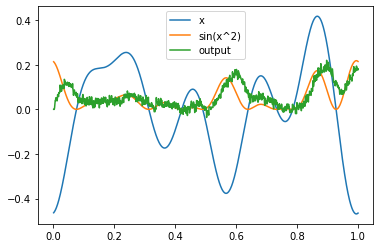

In [14]:
with nengo_dl.Simulator(
        net, minibatch_size=minibatch_size, seed=seed) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(0.01), 
                loss={outpt_p_nofilt: tf.losses.mse})
    sim.fit(inputs, targets, epochs=25)
    
    sim.run(1.0)
    plot(sim, idx=0)

If we compare this to the figure above, we can see that there has been some improvement.  However, it is better to use a quantitative measure of performance, discussed next.

## Evaluating model performance

As discussed above, the goal with training is usually to reduce some error value.  In order to evaluate how successful our training has been it is helpful to check what the value of that error is before and after optimization.  This can be done through the `sim.evaluate` function.

`sim.evaluate` works very analogously to `sim.fit`; we pass it some data, and it will compute an error value (based on the loss functions we specified in `sim.compile`).  Note that we can also evaluate loss functions other than those used during training, by using the `metrics` argument of `sim.compile`.

It is almost always the case that we want to use a different data set for evaluating the model's performance than we used during training.  Otherwise we might think that training has improved the performance of our model in general, when in fact it has only improved performance on that specific training data.  This is known as overfitting.

In [15]:
# create new set of random test data
test_vals = np.random.uniform(-1, 1, size=(1024, 1, 1))

Another important factor to keep in mind is that during training the spiking neurons in the model are automatically being swapped for differentiable rate neurons.  This is one of the reasons that we only needed to run the training for a single timestep (rate neurons compute their output instantaneously, whereas spiking neurons need to accumulate voltage and spike over time).  By default, `sim.evaluate` does not change the neuron models in this way.  This is what we want, because it is the performance of the model we defined, which contains spiking neurons, that we want to evaluate.  However, this does mean that we need to increase the value of `n_steps` for the testing data.  In addition, we will use the output probe with the synaptic filter, in order to get a less noisy estimate of the model's output.

In [16]:
# repeat test data for a number of timesteps
test_steps = 100
test_vals = np.tile(test_vals, (1, test_steps, 1))

# create test data dictionary
# note: using outpt_p instead of outpt_p_nofilt
test_inputs = {inpt: test_vals}
test_targets = {outpt_p: np.sin(test_vals**2)}

We'll also define a custom objective function.  The initial output of the model will be dominated by startup artifacts (e.g., synaptic filter effects), and not indicative of the model's optimized performance.  So we'll define a version of mean squared error that only looks at the model's output from the last 10 timesteps, in order to get a more meaningful measure of how much the performance improves with training.

In [17]:
def test_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred[:, -10:] - y_true[:, -10:]))

Now we are ready to evaluate the model's performance.  We will do the same thing we did in the training example above, but also evaluate the performance of our model on the test data before and after training.

In [18]:
with nengo_dl.Simulator(
        net, minibatch_size=minibatch_size, seed=seed) as sim:
    sim.compile(loss={outpt_p: test_mse})
    print("Error before training:", sim.evaluate(test_inputs, test_targets)["loss"])
    
    # run the training, same as in the previous section
    sim.compile(optimizer=tf.optimizers.RMSprop(0.01), 
                loss={outpt_p_nofilt: tf.losses.mse})
    sim.fit(inputs, targets, epochs=25)
    
    sim.compile(loss={outpt_p: test_mse})
    print("Error after training:", sim.evaluate(test_inputs, test_targets)["loss"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|####          Constructing graph: build stage (6%)              | ETA: 0:00:01

|##############Constructing graph: build stage (33%)             | ETA: 0:00:00

|##############Constructing graph: build stage (60%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|   #                     Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Error before training: 0.005054158486018423


Train on 4096 samples
Epoch 1/25


  32/4096 [..............................] - ETA: 0s - loss: 0.0028 - probe_2_loss: 0.0028

 352/4096 [=>............................] - ETA: 0s - loss: 0.0022 - probe_2_loss: 0.0022

 672/4096 [===>..........................] - ETA: 0s - loss: 0.0022 - probe_2_loss: 0.0022

 992/4096 [======>.......................] - ETA: 0s - loss: 0.0022 - probe_2_loss: 0.0022

1344/4096 [========>.....................] - ETA: 0s - loss: 0.0021 - probe_2_loss: 0.0021

1696/4096 [===========>..................] - ETA: 0s - loss: 0.0020 - probe_2_loss: 0.0020

2048/4096 [==============>...............] - ETA: 0s - loss: 0.0020 - probe_2_loss: 0.0020

2400/4096 [================>.............] - ETA: 0s - loss: 0.0020 - probe_2_loss: 0.0020

2752/4096 [===================>..........] - ETA: 0s - loss: 0.0020 - probe_2_loss: 0.0020

3104/4096 [=====================>........] - ETA: 0s - loss: 0.0020 - probe_2_loss: 0.0020

3456/4096 [========================>.....] - ETA: 0s - loss: 0.0020 - probe_2_loss: 0.0020

3808/4096 [==========================>...] - ETA: 0s - loss: 0.0020 - probe_2_loss: 0.0020

4096/4096 [==============================] - 1s 151us/sample - loss: 0.0020 - probe_2_loss: 0.0020


Epoch 2/25
  32/4096 [..............................] - ETA: 0s - loss: 0.0020 - probe_2_loss: 0.0020

 384/4096 [=>............................] - ETA: 0s - loss: 0.0018 - probe_2_loss: 0.0018

 736/4096 [====>.........................] - ETA: 0s - loss: 0.0018 - probe_2_loss: 0.0018

1088/4096 [======>.......................] - ETA: 0s - loss: 0.0018 - probe_2_loss: 0.0018

1440/4096 [=========>....................] - ETA: 0s - loss: 0.0018 - probe_2_loss: 0.0018

1792/4096 [============>.................] - ETA: 0s - loss: 0.0018 - probe_2_loss: 0.0018

2144/4096 [==============>...............] - ETA: 0s - loss: 0.0018 - probe_2_loss: 0.0018

2496/4096 [=================>............] - ETA: 0s - loss: 0.0018 - probe_2_loss: 0.0018

2848/4096 [===================>..........] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

3200/4096 [======================>.......] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

3552/4096 [=========================>....] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

3904/4096 [===========================>..] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

4096/4096 [==============================] - 1s 147us/sample - loss: 0.0017 - probe_2_loss: 0.0017


Epoch 3/25
  32/4096 [..............................] - ETA: 0s - loss: 0.0014 - probe_2_loss: 0.0014

 384/4096 [=>............................] - ETA: 0s - loss: 0.0020 - probe_2_loss: 0.0020

 736/4096 [====>.........................] - ETA: 0s - loss: 0.0018 - probe_2_loss: 0.0018

1088/4096 [======>.......................] - ETA: 0s - loss: 0.0018 - probe_2_loss: 0.0018

1440/4096 [=========>....................] - ETA: 0s - loss: 0.0017 - probe_2_loss: 0.0017

1792/4096 [============>.................] - ETA: 0s - loss: 0.0016 - probe_2_loss: 0.0016

2144/4096 [==============>...............] - ETA: 0s - loss: 0.0016 - probe_2_loss: 0.0016

2496/4096 [=================>............] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

2848/4096 [===================>..........] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

3200/4096 [======================>.......] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

3552/4096 [=========================>....] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

3904/4096 [===========================>..] - ETA: 0s - loss: 0.0015 - probe_2_loss: 0.0015

4096/4096 [==============================] - 1s 147us/sample - loss: 0.0015 - probe_2_loss: 0.0015


Epoch 4/25
  32/4096 [..............................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

 352/4096 [=>............................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

 704/4096 [====>.........................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

1056/4096 [======>.......................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

1408/4096 [=========>....................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

1760/4096 [===========>..................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

2112/4096 [==============>...............] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

2464/4096 [=================>............] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

2816/4096 [===================>..........] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

3168/4096 [======================>.......] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

3520/4096 [========================>.....] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

3872/4096 [===========================>..] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

4096/4096 [==============================] - 1s 154us/sample - loss: 0.0013 - probe_2_loss: 0.0013


Epoch 5/25
  32/4096 [..............................] - ETA: 0s - loss: 0.0013 - probe_2_loss: 0.0013

 384/4096 [=>............................] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

 704/4096 [====>.........................] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

1056/4096 [======>.......................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

1344/4096 [========>.....................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

1696/4096 [===========>..................] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

2048/4096 [==============>...............] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

2400/4096 [================>.............] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

2720/4096 [==================>...........] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

3072/4096 [=====================>........] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

3424/4096 [========================>.....] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

3776/4096 [==========================>...] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

4096/4096 [==============================] - 1s 153us/sample - loss: 0.0012 - probe_2_loss: 0.0012


Epoch 6/25
  32/4096 [..............................] - ETA: 0s - loss: 0.0014 - probe_2_loss: 0.0014

 384/4096 [=>............................] - ETA: 0s - loss: 0.0010 - probe_2_loss: 0.0010

 736/4096 [====>.........................] - ETA: 0s - loss: 0.0010 - probe_2_loss: 0.0010

1088/4096 [======>.......................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

1440/4096 [=========>....................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

1792/4096 [============>.................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

2144/4096 [==============>...............] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

2496/4096 [=================>............] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

2848/4096 [===================>..........] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

3040/4096 [=====================>........] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

3392/4096 [=======================>......] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

3744/4096 [==========================>...] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

4096/4096 [==============================] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

4096/4096 [==============================] - 1s 155us/sample - loss: 0.0011 - probe_2_loss: 0.0011


Epoch 7/25
  32/4096 [..............................] - ETA: 0s - loss: 0.0011 - probe_2_loss: 0.0011

 384/4096 [=>............................] - ETA: 0s - loss: 8.8961e-04 - probe_2_loss: 8.8961e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 9.5261e-04 - probe_2_loss: 9.5261e-04

1056/4096 [======>.......................] - ETA: 0s - loss: 9.6934e-04 - probe_2_loss: 9.6934e-04

1408/4096 [=========>....................] - ETA: 0s - loss: 9.9044e-04 - probe_2_loss: 9.9044e-04

1760/4096 [===========>..................] - ETA: 0s - loss: 9.8326e-04 - probe_2_loss: 9.8326e-04

2112/4096 [==============>...............] - ETA: 0s - loss: 9.9356e-04 - probe_2_loss: 9.9356e-04

2464/4096 [=================>............] - ETA: 0s - loss: 9.7451e-04 - probe_2_loss: 9.7451e-04

2816/4096 [===================>..........] - ETA: 0s - loss: 9.7956e-04 - probe_2_loss: 9.7956e-04

3168/4096 [======================>.......] - ETA: 0s - loss: 9.6150e-04 - probe_2_loss: 9.6150e-04

3520/4096 [========================>.....] - ETA: 0s - loss: 9.5582e-04 - probe_2_loss: 9.5582e-04

3808/4096 [==========================>...] - ETA: 0s - loss: 9.4343e-04 - probe_2_loss: 9.4343e-04

4096/4096 [==============================] - ETA: 0s - loss: 9.3963e-04 - probe_2_loss: 9.3963e-04

4096/4096 [==============================] - 1s 154us/sample - loss: 9.3963e-04 - probe_2_loss: 9.3963e-04


Epoch 8/25
  32/4096 [..............................] - ETA: 0s - loss: 0.0012 - probe_2_loss: 0.0012

 320/4096 [=>............................] - ETA: 0s - loss: 9.0157e-04 - probe_2_loss: 9.0157e-04

 672/4096 [===>..........................] - ETA: 0s - loss: 8.7478e-04 - probe_2_loss: 8.7478e-04

1024/4096 [======>.......................] - ETA: 0s - loss: 9.1755e-04 - probe_2_loss: 9.1755e-04

1376/4096 [=========>....................] - ETA: 0s - loss: 8.8355e-04 - probe_2_loss: 8.8355e-04

1728/4096 [===========>..................] - ETA: 0s - loss: 8.7792e-04 - probe_2_loss: 8.7792e-04

2048/4096 [==============>...............] - ETA: 0s - loss: 8.7466e-04 - probe_2_loss: 8.7466e-04

2400/4096 [================>.............] - ETA: 0s - loss: 8.6306e-04 - probe_2_loss: 8.6306e-04

2752/4096 [===================>..........] - ETA: 0s - loss: 8.6467e-04 - probe_2_loss: 8.6467e-04

3104/4096 [=====================>........] - ETA: 0s - loss: 8.6042e-04 - probe_2_loss: 8.6042e-04

3456/4096 [========================>.....] - ETA: 0s - loss: 8.5655e-04 - probe_2_loss: 8.5655e-04

3808/4096 [==========================>...] - ETA: 0s - loss: 8.4381e-04 - probe_2_loss: 8.4381e-04

4096/4096 [==============================] - 1s 152us/sample - loss: 8.4891e-04 - probe_2_loss: 8.4891e-04


Epoch 9/25
  32/4096 [..............................] - ETA: 0s - loss: 3.8294e-04 - probe_2_loss: 3.8294e-04

 384/4096 [=>............................] - ETA: 0s - loss: 8.0925e-04 - probe_2_loss: 8.0925e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 8.5033e-04 - probe_2_loss: 8.5033e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 8.3457e-04 - probe_2_loss: 8.3457e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 8.2949e-04 - probe_2_loss: 8.2949e-04

1792/4096 [============>.................] - ETA: 0s - loss: 8.2658e-04 - probe_2_loss: 8.2658e-04

2144/4096 [==============>...............] - ETA: 0s - loss: 8.0219e-04 - probe_2_loss: 8.0219e-04

2496/4096 [=================>............] - ETA: 0s - loss: 7.9798e-04 - probe_2_loss: 7.9798e-04

2848/4096 [===================>..........] - ETA: 0s - loss: 7.8666e-04 - probe_2_loss: 7.8666e-04

3072/4096 [=====================>........] - ETA: 0s - loss: 7.8361e-04 - probe_2_loss: 7.8361e-04

3392/4096 [=======================>......] - ETA: 0s - loss: 7.8166e-04 - probe_2_loss: 7.8166e-04

3712/4096 [==========================>...] - ETA: 0s - loss: 7.8153e-04 - probe_2_loss: 7.8153e-04

4064/4096 [============================>.] - ETA: 0s - loss: 7.7587e-04 - probe_2_loss: 7.7587e-04

4096/4096 [==============================] - 1s 153us/sample - loss: 7.7582e-04 - probe_2_loss: 7.7582e-04


Epoch 10/25
  32/4096 [..............................] - ETA: 0s - loss: 7.8337e-04 - probe_2_loss: 7.8337e-04

 384/4096 [=>............................] - ETA: 0s - loss: 7.5511e-04 - probe_2_loss: 7.5511e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 7.3190e-04 - probe_2_loss: 7.3190e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 7.7594e-04 - probe_2_loss: 7.7594e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 7.6313e-04 - probe_2_loss: 7.6313e-04

1792/4096 [============>.................] - ETA: 0s - loss: 7.6002e-04 - probe_2_loss: 7.6002e-04

2112/4096 [==============>...............] - ETA: 0s - loss: 7.7397e-04 - probe_2_loss: 7.7397e-04

2464/4096 [=================>............] - ETA: 0s - loss: 7.6428e-04 - probe_2_loss: 7.6428e-04

2816/4096 [===================>..........] - ETA: 0s - loss: 7.4922e-04 - probe_2_loss: 7.4922e-04

3136/4096 [=====================>........] - ETA: 0s - loss: 7.2978e-04 - probe_2_loss: 7.2978e-04

3488/4096 [========================>.....] - ETA: 0s - loss: 7.3104e-04 - probe_2_loss: 7.3104e-04

3840/4096 [===========================>..] - ETA: 0s - loss: 7.2260e-04 - probe_2_loss: 7.2260e-04

4096/4096 [==============================] - 1s 149us/sample - loss: 7.1749e-04 - probe_2_loss: 7.1749e-04


Epoch 11/25


  32/4096 [..............................] - ETA: 0s - loss: 5.8643e-04 - probe_2_loss: 5.8643e-04

 288/4096 [=>............................] - ETA: 0s - loss: 6.0153e-04 - probe_2_loss: 6.0153e-04

 608/4096 [===>..........................] - ETA: 0s - loss: 6.9529e-04 - probe_2_loss: 6.9529e-04

 960/4096 [======>.......................] - ETA: 0s - loss: 6.7235e-04 - probe_2_loss: 6.7235e-04

1312/4096 [========>.....................] - ETA: 0s - loss: 6.6914e-04 - probe_2_loss: 6.6914e-04

1664/4096 [===========>..................] - ETA: 0s - loss: 6.6856e-04 - probe_2_loss: 6.6856e-04

2016/4096 [=============>................] - ETA: 0s - loss: 6.6800e-04 - probe_2_loss: 6.6800e-04

2368/4096 [================>.............] - ETA: 0s - loss: 6.7020e-04 - probe_2_loss: 6.7020e-04

2688/4096 [==================>...........] - ETA: 0s - loss: 6.6664e-04 - probe_2_loss: 6.6664e-04

2976/4096 [====================>.........] - ETA: 0s - loss: 6.6598e-04 - probe_2_loss: 6.6598e-04

3360/4096 [=======================>......] - ETA: 0s - loss: 6.7494e-04 - probe_2_loss: 6.7494e-04

3712/4096 [==========================>...] - ETA: 0s - loss: 6.7050e-04 - probe_2_loss: 6.7050e-04

4064/4096 [============================>.] - ETA: 0s - loss: 6.7034e-04 - probe_2_loss: 6.7034e-04

4096/4096 [==============================] - 1s 153us/sample - loss: 6.6842e-04 - probe_2_loss: 6.6842e-04


Epoch 12/25
  32/4096 [..............................] - ETA: 0s - loss: 5.5129e-04 - probe_2_loss: 5.5129e-04

 384/4096 [=>............................] - ETA: 0s - loss: 6.6675e-04 - probe_2_loss: 6.6675e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 6.4342e-04 - probe_2_loss: 6.4342e-04

1120/4096 [=======>......................] - ETA: 0s - loss: 6.5035e-04 - probe_2_loss: 6.5035e-04

1472/4096 [=========>....................] - ETA: 0s - loss: 6.2632e-04 - probe_2_loss: 6.2632e-04

1824/4096 [============>.................] - ETA: 0s - loss: 6.3970e-04 - probe_2_loss: 6.3970e-04

2176/4096 [==============>...............] - ETA: 0s - loss: 6.2323e-04 - probe_2_loss: 6.2323e-04

2528/4096 [=================>............] - ETA: 0s - loss: 6.3341e-04 - probe_2_loss: 6.3341e-04

2880/4096 [====================>.........] - ETA: 0s - loss: 6.1911e-04 - probe_2_loss: 6.1911e-04

3200/4096 [======================>.......] - ETA: 0s - loss: 6.2570e-04 - probe_2_loss: 6.2570e-04

3552/4096 [=========================>....] - ETA: 0s - loss: 6.2074e-04 - probe_2_loss: 6.2074e-04

3904/4096 [===========================>..] - ETA: 0s - loss: 6.2320e-04 - probe_2_loss: 6.2320e-04

4096/4096 [==============================] - 1s 148us/sample - loss: 6.2542e-04 - probe_2_loss: 6.2542e-04


Epoch 13/25
  32/4096 [..............................] - ETA: 0s - loss: 8.6870e-04 - probe_2_loss: 8.6870e-04

 384/4096 [=>............................] - ETA: 0s - loss: 6.7472e-04 - probe_2_loss: 6.7472e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 5.9117e-04 - probe_2_loss: 5.9117e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 6.0778e-04 - probe_2_loss: 6.0778e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 6.2718e-04 - probe_2_loss: 6.2718e-04

1760/4096 [===========>..................] - ETA: 0s - loss: 6.1702e-04 - probe_2_loss: 6.1702e-04

1984/4096 [=============>................] - ETA: 0s - loss: 6.1596e-04 - probe_2_loss: 6.1596e-04

2112/4096 [==============>...............] - ETA: 0s - loss: 6.1356e-04 - probe_2_loss: 6.1356e-04

2464/4096 [=================>............] - ETA: 0s - loss: 5.9896e-04 - probe_2_loss: 5.9896e-04

2816/4096 [===================>..........] - ETA: 0s - loss: 5.9273e-04 - probe_2_loss: 5.9273e-04

3200/4096 [======================>.......] - ETA: 0s - loss: 5.9352e-04 - probe_2_loss: 5.9352e-04

3552/4096 [=========================>....] - ETA: 0s - loss: 5.8356e-04 - probe_2_loss: 5.8356e-04

3904/4096 [===========================>..] - ETA: 0s - loss: 5.8599e-04 - probe_2_loss: 5.8599e-04

4096/4096 [==============================] - 1s 161us/sample - loss: 5.8575e-04 - probe_2_loss: 5.8575e-04


Epoch 14/25
  32/4096 [..............................] - ETA: 0s - loss: 4.3906e-04 - probe_2_loss: 4.3906e-04

 384/4096 [=>............................] - ETA: 0s - loss: 5.8042e-04 - probe_2_loss: 5.8042e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 5.3661e-04 - probe_2_loss: 5.3661e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 5.1413e-04 - probe_2_loss: 5.1413e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 5.4520e-04 - probe_2_loss: 5.4520e-04

1792/4096 [============>.................] - ETA: 0s - loss: 5.4752e-04 - probe_2_loss: 5.4752e-04

2112/4096 [==============>...............] - ETA: 0s - loss: 5.5852e-04 - probe_2_loss: 5.5852e-04

2464/4096 [=================>............] - ETA: 0s - loss: 5.5024e-04 - probe_2_loss: 5.5024e-04

2816/4096 [===================>..........] - ETA: 0s - loss: 5.4326e-04 - probe_2_loss: 5.4326e-04

3136/4096 [=====================>........] - ETA: 0s - loss: 5.5020e-04 - probe_2_loss: 5.5020e-04

3488/4096 [========================>.....] - ETA: 0s - loss: 5.4989e-04 - probe_2_loss: 5.4989e-04

3840/4096 [===========================>..] - ETA: 0s - loss: 5.4823e-04 - probe_2_loss: 5.4823e-04

4096/4096 [==============================] - 1s 151us/sample - loss: 5.5279e-04 - probe_2_loss: 5.5279e-04


Epoch 15/25


  32/4096 [..............................] - ETA: 0s - loss: 6.4875e-04 - probe_2_loss: 6.4875e-04

 384/4096 [=>............................] - ETA: 0s - loss: 5.6761e-04 - probe_2_loss: 5.6761e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 5.2191e-04 - probe_2_loss: 5.2191e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 5.2035e-04 - probe_2_loss: 5.2035e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 5.2437e-04 - probe_2_loss: 5.2437e-04

1792/4096 [============>.................] - ETA: 0s - loss: 5.2952e-04 - probe_2_loss: 5.2952e-04

2144/4096 [==============>...............] - ETA: 0s - loss: 5.2826e-04 - probe_2_loss: 5.2826e-04

2496/4096 [=================>............] - ETA: 0s - loss: 5.3632e-04 - probe_2_loss: 5.3632e-04

2848/4096 [===================>..........] - ETA: 0s - loss: 5.3345e-04 - probe_2_loss: 5.3345e-04

3200/4096 [======================>.......] - ETA: 0s - loss: 5.3082e-04 - probe_2_loss: 5.3082e-04

3552/4096 [=========================>....] - ETA: 0s - loss: 5.3167e-04 - probe_2_loss: 5.3167e-04

3904/4096 [===========================>..] - ETA: 0s - loss: 5.2977e-04 - probe_2_loss: 5.2977e-04

4096/4096 [==============================] - 1s 147us/sample - loss: 5.2542e-04 - probe_2_loss: 5.2542e-04


Epoch 16/25
  32/4096 [..............................] - ETA: 0s - loss: 5.6180e-04 - probe_2_loss: 5.6180e-04

 384/4096 [=>............................] - ETA: 0s - loss: 4.7559e-04 - probe_2_loss: 4.7559e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 5.1566e-04 - probe_2_loss: 5.1566e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 5.1354e-04 - probe_2_loss: 5.1354e-04

1408/4096 [=========>....................] - ETA: 0s - loss: 5.2757e-04 - probe_2_loss: 5.2757e-04

1728/4096 [===========>..................] - ETA: 0s - loss: 5.2328e-04 - probe_2_loss: 5.2328e-04

2048/4096 [==============>...............] - ETA: 0s - loss: 5.2937e-04 - probe_2_loss: 5.2937e-04

2400/4096 [================>.............] - ETA: 0s - loss: 5.1213e-04 - probe_2_loss: 5.1213e-04

2752/4096 [===================>..........] - ETA: 0s - loss: 5.0759e-04 - probe_2_loss: 5.0759e-04

3072/4096 [=====================>........] - ETA: 0s - loss: 5.0811e-04 - probe_2_loss: 5.0811e-04

3424/4096 [========================>.....] - ETA: 0s - loss: 5.0330e-04 - probe_2_loss: 5.0330e-04

3776/4096 [==========================>...] - ETA: 0s - loss: 5.0419e-04 - probe_2_loss: 5.0419e-04

4096/4096 [==============================] - 1s 153us/sample - loss: 4.9539e-04 - probe_2_loss: 4.9539e-04


Epoch 17/25
  32/4096 [..............................] - ETA: 0s - loss: 5.5346e-04 - probe_2_loss: 5.5346e-04

 384/4096 [=>............................] - ETA: 0s - loss: 4.5211e-04 - probe_2_loss: 4.5211e-04

 704/4096 [====>.........................] - ETA: 0s - loss: 4.8166e-04 - probe_2_loss: 4.8166e-04

1056/4096 [======>.......................] - ETA: 0s - loss: 4.6740e-04 - probe_2_loss: 4.6740e-04

1408/4096 [=========>....................] - ETA: 0s - loss: 4.8236e-04 - probe_2_loss: 4.8236e-04

1760/4096 [===========>..................] - ETA: 0s - loss: 4.7822e-04 - probe_2_loss: 4.7822e-04

2112/4096 [==============>...............] - ETA: 0s - loss: 4.8016e-04 - probe_2_loss: 4.8016e-04

2464/4096 [=================>............] - ETA: 0s - loss: 4.7217e-04 - probe_2_loss: 4.7217e-04

2816/4096 [===================>..........] - ETA: 0s - loss: 4.6749e-04 - probe_2_loss: 4.6749e-04

3168/4096 [======================>.......] - ETA: 0s - loss: 4.6745e-04 - probe_2_loss: 4.6745e-04

3520/4096 [========================>.....] - ETA: 0s - loss: 4.6137e-04 - probe_2_loss: 4.6137e-04

3872/4096 [===========================>..] - ETA: 0s - loss: 4.7356e-04 - probe_2_loss: 4.7356e-04

4096/4096 [==============================] - 1s 150us/sample - loss: 4.7189e-04 - probe_2_loss: 4.7189e-04


Epoch 18/25
  32/4096 [..............................] - ETA: 0s - loss: 6.2546e-04 - probe_2_loss: 6.2546e-04

 384/4096 [=>............................] - ETA: 0s - loss: 5.2755e-04 - probe_2_loss: 5.2755e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 4.7775e-04 - probe_2_loss: 4.7775e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 4.6395e-04 - probe_2_loss: 4.6395e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 4.6586e-04 - probe_2_loss: 4.6586e-04

1792/4096 [============>.................] - ETA: 0s - loss: 4.6230e-04 - probe_2_loss: 4.6230e-04

2144/4096 [==============>...............] - ETA: 0s - loss: 4.5510e-04 - probe_2_loss: 4.5510e-04

2496/4096 [=================>............] - ETA: 0s - loss: 4.6021e-04 - probe_2_loss: 4.6021e-04

2848/4096 [===================>..........] - ETA: 0s - loss: 4.5191e-04 - probe_2_loss: 4.5191e-04

3200/4096 [======================>.......] - ETA: 0s - loss: 4.5284e-04 - probe_2_loss: 4.5284e-04

3552/4096 [=========================>....] - ETA: 0s - loss: 4.4960e-04 - probe_2_loss: 4.4960e-04

3904/4096 [===========================>..] - ETA: 0s - loss: 4.5489e-04 - probe_2_loss: 4.5489e-04

4096/4096 [==============================] - 1s 147us/sample - loss: 4.5059e-04 - probe_2_loss: 4.5059e-04


Epoch 19/25
  32/4096 [..............................] - ETA: 0s - loss: 2.8899e-04 - probe_2_loss: 2.8899e-04

 384/4096 [=>............................] - ETA: 0s - loss: 4.1609e-04 - probe_2_loss: 4.1609e-04

 768/4096 [====>.........................] - ETA: 0s - loss: 4.1771e-04 - probe_2_loss: 4.1771e-04

1120/4096 [=======>......................] - ETA: 0s - loss: 4.3648e-04 - probe_2_loss: 4.3648e-04

1472/4096 [=========>....................] - ETA: 0s - loss: 4.4736e-04 - probe_2_loss: 4.4736e-04

1824/4096 [============>.................] - ETA: 0s - loss: 4.5654e-04 - probe_2_loss: 4.5654e-04

2176/4096 [==============>...............] - ETA: 0s - loss: 4.5578e-04 - probe_2_loss: 4.5578e-04

2528/4096 [=================>............] - ETA: 0s - loss: 4.3856e-04 - probe_2_loss: 4.3856e-04

2880/4096 [====================>.........] - ETA: 0s - loss: 4.3757e-04 - probe_2_loss: 4.3757e-04

3232/4096 [======================>.......] - ETA: 0s - loss: 4.3393e-04 - probe_2_loss: 4.3393e-04

3584/4096 [=========================>....] - ETA: 0s - loss: 4.3595e-04 - probe_2_loss: 4.3595e-04

3936/4096 [===========================>..] - ETA: 0s - loss: 4.3458e-04 - probe_2_loss: 4.3458e-04

4096/4096 [==============================] - 1s 148us/sample - loss: 4.3149e-04 - probe_2_loss: 4.3149e-04


Epoch 20/25
  32/4096 [..............................] - ETA: 0s - loss: 4.8975e-04 - probe_2_loss: 4.8975e-04

 384/4096 [=>............................] - ETA: 0s - loss: 4.2775e-04 - probe_2_loss: 4.2775e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 4.0287e-04 - probe_2_loss: 4.0287e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 3.9716e-04 - probe_2_loss: 3.9716e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 4.1701e-04 - probe_2_loss: 4.1701e-04

1792/4096 [============>.................] - ETA: 0s - loss: 4.0566e-04 - probe_2_loss: 4.0567e-04

2144/4096 [==============>...............] - ETA: 0s - loss: 4.0406e-04 - probe_2_loss: 4.0406e-04

2496/4096 [=================>............] - ETA: 0s - loss: 4.0668e-04 - probe_2_loss: 4.0668e-04

2848/4096 [===================>..........] - ETA: 0s - loss: 4.2257e-04 - probe_2_loss: 4.2257e-04

3200/4096 [======================>.......] - ETA: 0s - loss: 4.2130e-04 - probe_2_loss: 4.2130e-04

3552/4096 [=========================>....] - ETA: 0s - loss: 4.1772e-04 - probe_2_loss: 4.1772e-04

3904/4096 [===========================>..] - ETA: 0s - loss: 4.1354e-04 - probe_2_loss: 4.1354e-04

4096/4096 [==============================] - 1s 149us/sample - loss: 4.1407e-04 - probe_2_loss: 4.1407e-04


Epoch 21/25
  32/4096 [..............................] - ETA: 0s - loss: 5.2602e-04 - probe_2_loss: 5.2602e-04

 384/4096 [=>............................] - ETA: 0s - loss: 4.3811e-04 - probe_2_loss: 4.3811e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 3.9090e-04 - probe_2_loss: 3.9090e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 3.9444e-04 - probe_2_loss: 3.9444e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 4.0793e-04 - probe_2_loss: 4.0793e-04

1792/4096 [============>.................] - ETA: 0s - loss: 4.0840e-04 - probe_2_loss: 4.0840e-04

2144/4096 [==============>...............] - ETA: 0s - loss: 4.0802e-04 - probe_2_loss: 4.0802e-04

2400/4096 [================>.............] - ETA: 0s - loss: 4.1800e-04 - probe_2_loss: 4.1800e-04

2720/4096 [==================>...........] - ETA: 0s - loss: 4.1454e-04 - probe_2_loss: 4.1454e-04

3040/4096 [=====================>........] - ETA: 0s - loss: 4.0907e-04 - probe_2_loss: 4.0907e-04

3392/4096 [=======================>......] - ETA: 0s - loss: 4.1145e-04 - probe_2_loss: 4.1145e-04

3744/4096 [==========================>...] - ETA: 0s - loss: 4.0459e-04 - probe_2_loss: 4.0459e-04

4096/4096 [==============================] - ETA: 0s - loss: 3.9812e-04 - probe_2_loss: 3.9812e-04

4096/4096 [==============================] - 1s 156us/sample - loss: 3.9812e-04 - probe_2_loss: 3.9812e-04


Epoch 22/25
  32/4096 [..............................] - ETA: 0s - loss: 2.3917e-04 - probe_2_loss: 2.3917e-04

 384/4096 [=>............................] - ETA: 0s - loss: 3.2467e-04 - probe_2_loss: 3.2467e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 3.6306e-04 - probe_2_loss: 3.6306e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 3.9145e-04 - probe_2_loss: 3.9145e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 4.0282e-04 - probe_2_loss: 4.0282e-04

1792/4096 [============>.................] - ETA: 0s - loss: 3.9147e-04 - probe_2_loss: 3.9147e-04

2144/4096 [==============>...............] - ETA: 0s - loss: 3.9528e-04 - probe_2_loss: 3.9528e-04

2464/4096 [=================>............] - ETA: 0s - loss: 3.9410e-04 - probe_2_loss: 3.9410e-04

2816/4096 [===================>..........] - ETA: 0s - loss: 3.8908e-04 - probe_2_loss: 3.8908e-04

3168/4096 [======================>.......] - ETA: 0s - loss: 3.7971e-04 - probe_2_loss: 3.7971e-04

3520/4096 [========================>.....] - ETA: 0s - loss: 3.7581e-04 - probe_2_loss: 3.7581e-04

3872/4096 [===========================>..] - ETA: 0s - loss: 3.8022e-04 - probe_2_loss: 3.8022e-04

4096/4096 [==============================] - 1s 151us/sample - loss: 3.8274e-04 - probe_2_loss: 3.8274e-04


Epoch 23/25
  32/4096 [..............................] - ETA: 0s - loss: 1.5399e-04 - probe_2_loss: 1.5399e-04

 384/4096 [=>............................] - ETA: 0s - loss: 3.0538e-04 - probe_2_loss: 3.0538e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 3.5244e-04 - probe_2_loss: 3.5244e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 3.6014e-04 - probe_2_loss: 3.6014e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 3.6161e-04 - probe_2_loss: 3.6161e-04

1792/4096 [============>.................] - ETA: 0s - loss: 3.7282e-04 - probe_2_loss: 3.7282e-04

2144/4096 [==============>...............] - ETA: 0s - loss: 3.7811e-04 - probe_2_loss: 3.7811e-04

2496/4096 [=================>............] - ETA: 0s - loss: 3.7246e-04 - probe_2_loss: 3.7246e-04

2848/4096 [===================>..........] - ETA: 0s - loss: 3.7003e-04 - probe_2_loss: 3.7003e-04

3168/4096 [======================>.......] - ETA: 0s - loss: 3.6654e-04 - probe_2_loss: 3.6654e-04

3520/4096 [========================>.....] - ETA: 0s - loss: 3.7007e-04 - probe_2_loss: 3.7007e-04

3872/4096 [===========================>..] - ETA: 0s - loss: 3.6714e-04 - probe_2_loss: 3.6714e-04

4096/4096 [==============================] - 1s 148us/sample - loss: 3.6735e-04 - probe_2_loss: 3.6735e-04


Epoch 24/25
  32/4096 [..............................] - ETA: 0s - loss: 3.0363e-04 - probe_2_loss: 3.0363e-04

 384/4096 [=>............................] - ETA: 0s - loss: 2.9891e-04 - probe_2_loss: 2.9891e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 3.3486e-04 - probe_2_loss: 3.3486e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 3.3065e-04 - probe_2_loss: 3.3065e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 3.3591e-04 - probe_2_loss: 3.3591e-04

1792/4096 [============>.................] - ETA: 0s - loss: 3.3853e-04 - probe_2_loss: 3.3853e-04

2080/4096 [==============>...............] - ETA: 0s - loss: 3.4559e-04 - probe_2_loss: 3.4559e-04

2432/4096 [================>.............] - ETA: 0s - loss: 3.4860e-04 - probe_2_loss: 3.4860e-04

2784/4096 [===================>..........] - ETA: 0s - loss: 3.6182e-04 - probe_2_loss: 3.6182e-04

3136/4096 [=====================>........] - ETA: 0s - loss: 3.5734e-04 - probe_2_loss: 3.5734e-04

3488/4096 [========================>.....] - ETA: 0s - loss: 3.5546e-04 - probe_2_loss: 3.5546e-04

3840/4096 [===========================>..] - ETA: 0s - loss: 3.5761e-04 - probe_2_loss: 3.5761e-04

4096/4096 [==============================] - 1s 151us/sample - loss: 3.5295e-04 - probe_2_loss: 3.5295e-04


Epoch 25/25


  32/4096 [..............................] - ETA: 0s - loss: 4.5496e-04 - probe_2_loss: 4.5496e-04

 384/4096 [=>............................] - ETA: 0s - loss: 4.2987e-04 - probe_2_loss: 4.2987e-04

 736/4096 [====>.........................] - ETA: 0s - loss: 3.6027e-04 - probe_2_loss: 3.6027e-04

1088/4096 [======>.......................] - ETA: 0s - loss: 3.2860e-04 - probe_2_loss: 3.2860e-04

1440/4096 [=========>....................] - ETA: 0s - loss: 3.3175e-04 - probe_2_loss: 3.3175e-04

1792/4096 [============>.................] - ETA: 0s - loss: 3.2303e-04 - probe_2_loss: 3.2303e-04

2144/4096 [==============>...............] - ETA: 0s - loss: 3.2661e-04 - probe_2_loss: 3.2661e-04

2496/4096 [=================>............] - ETA: 0s - loss: 3.3131e-04 - probe_2_loss: 3.3131e-04

2848/4096 [===================>..........] - ETA: 0s - loss: 3.4052e-04 - probe_2_loss: 3.4052e-04

3200/4096 [======================>.......] - ETA: 0s - loss: 3.4144e-04 - probe_2_loss: 3.4144e-04

3552/4096 [=========================>....] - ETA: 0s - loss: 3.4152e-04 - probe_2_loss: 3.4152e-04

3904/4096 [===========================>..] - ETA: 0s - loss: 3.4252e-04 - probe_2_loss: 3.4252e-04

4096/4096 [==============================] - 1s 149us/sample - loss: 3.3837e-04 - probe_2_loss: 3.3837e-04


Error after training: 0.0028604232502402738


We can now say with more confidence that optimizing the encoders and biases has improved the accuracy of the model by about 50%.

## Integrating TensorFlow code

Another important feature of NengoDL is the ability to add TensorFlow code into a Nengo model.  For example, we could use a convolutional vision network, defined in TensorFlow, as the input to a cognitive Nengo model.  However, we'll keep things simple in this example and just use TensorFlow to compute the exponent of our output (so that overall the network is computing $e^{\sin(x^2)}$).  Note that for something like this we don't really need to use TensorFlow; we can accomplish the same thing with normal Nengo syntax.  The goal here is just to introduce the methodology in a simple case; see [this example](https://www.nengo.ai/nengo-dl/examples/pretrained-model.html) for a more practical example of integrating TensorFlow code in NengoDL.

TensorFlow code is inserted using `TensorNodes`.  A `TensorNode` works much the same way as a regular `nengo.Node`, except that instead of specifying the Node output using Python/NumPy functions, we use TensorFlow functions.

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

| #                       Constructing graph                          | 0:00:00

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###########   Constructing graph: build stage (17%)             | ETA: 0:00:00

|##############Constructing graph: build stage (35%)             | ETA: 0:00:00

|##############Constructing graph: build stage (41%)             | ETA: 0:00:00

|##############Constructing graph: build stage (52%)             | ETA: 0:00:00

|##############Constructing graph: build stage (64%)             | ETA: 0:00:00

|##############Constructing graph: build stage (70%)             | ETA: 0:00:00

|##############Constructing graph: build stage (88%)#####        | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|      #                  Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

|          #                  Simulating                              | 0:00:01

|           #                 Simulating                              | 0:00:01

|            #                Simulating                              | 0:00:01

|             #               Simulating                              | 0:00:01

|              #              Simulating                              | 0:00:01

|               #             Simulating                              | 0:00:01

|                #            Simulating                              | 0:00:01

|                 #           Simulating                              | 0:00:01

|                  #          Simulating                              | 0:00:01

|                   #         Simulating                              | 0:00:01

Simulation finished in 0:00:02                                                 

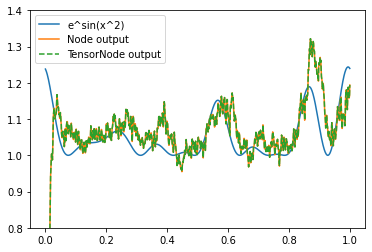

In [19]:
with net:
    # here is how we would accomplish this with a regular nengo Node
    exp_np = nengo.Node(lambda t, x: np.exp(x), size_in=1)
    nengo.Connection(sin, exp_np)
    np_probe = nengo.Probe(exp_np, synapse=0.01)
    
    # here is how we do the same using a TensorNode
    exp_tf = nengo_dl.TensorNode(lambda t, x: tf.exp(x), shape_in=(1,))
    nengo.Connection(sin, exp_tf)
    tf_probe = nengo.Probe(exp_tf, synapse=0.01)
    
with nengo_dl.Simulator(net, seed=seed) as sim:
    sim.run(1.0)
    
plt.figure()
plt.plot(sim.trange(), np.exp(np.sin(sim.data[inpt_p]**2)), 
         label="e^sin(x^2)")
plt.plot(sim.trange(), sim.data[np_probe], label="Node output")
plt.plot(sim.trange(), sim.data[tf_probe], label="TensorNode output",
         linestyle="--")
plt.ylim([0.8, 1.4])
plt.legend();

We can see that the `nengo.Node` and `nengo_dl.TensorNode` are producing the same output, as we would expect.  But under the hood, one is being computed in NumPy and the other is being computed in TensorFlow.

More details on TensorNode usage can be found in [the user guide](https://www.nengo.ai/nengo-dl/tensor-node.html).

## Conclusion

In this tutorial we have introduced the NengoDL Simulator, batch processing, dynamically specifying input values, optimizing model parameters using deep learning methods, and integrating TensorFlow code into a Nengo model.  This will allow you to begin to take advantage of the new features NengoDL adds to the Nengo toolkit.  However, there is much more functionality in NengoDL than we are able to introduce here; check out the [user guide](https://www.nengo.ai/nengo-dl/user-guide.html) or [other examples](https://www.nengo.ai/nengo-dl/examples.html) for more information.